In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Get The Data

### Download The Data

This dataset is a modified version of the California Housing dataset available from [Luís Torgo](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)'s page (University of Porto).

In [2]:
import os

download_root = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
housing_path = os.path.join('datasets', 'housing')
housing_url = download_root + 'datasets/housing/housing.tgz'

In [3]:
import tarfile
import urllib

def fetch_data(dataset_url, dataset_path, dataset_tgz):
    os.makedirs(dataset_path, exist_ok=True)
    tgz_path = os.path.join(dataset_path, dataset_tgz)
    urllib.request.urlretrieve(dataset_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=dataset_path)
    housing_tgz.close()

### Import The Data

In [4]:
def load_data(dataset_path, dataset_csv):
    csv_path = os.path.join(dataset_path, dataset_csv)
    return pd.read_csv(csv_path)

In [5]:
fetch_data(housing_url, housing_path, 'housing.tgz')

housing = load_data(housing_path, 'housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Overview About Data

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


This dataset has 20640 instances and 10 attributes, each attribute has 20640 non-null values except total_rooms with 20433 non-null values, which means it has 207 missing values that should be considered while cleaning.
All the attributes has numerical entries except ocean_proximity which has objects.

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Additional data about our dataset's value counts are the average of each attribute, standard deviation, and the five numbers summary.

Let's plot the frequency of each attribute to have insights about what we are dealing with.

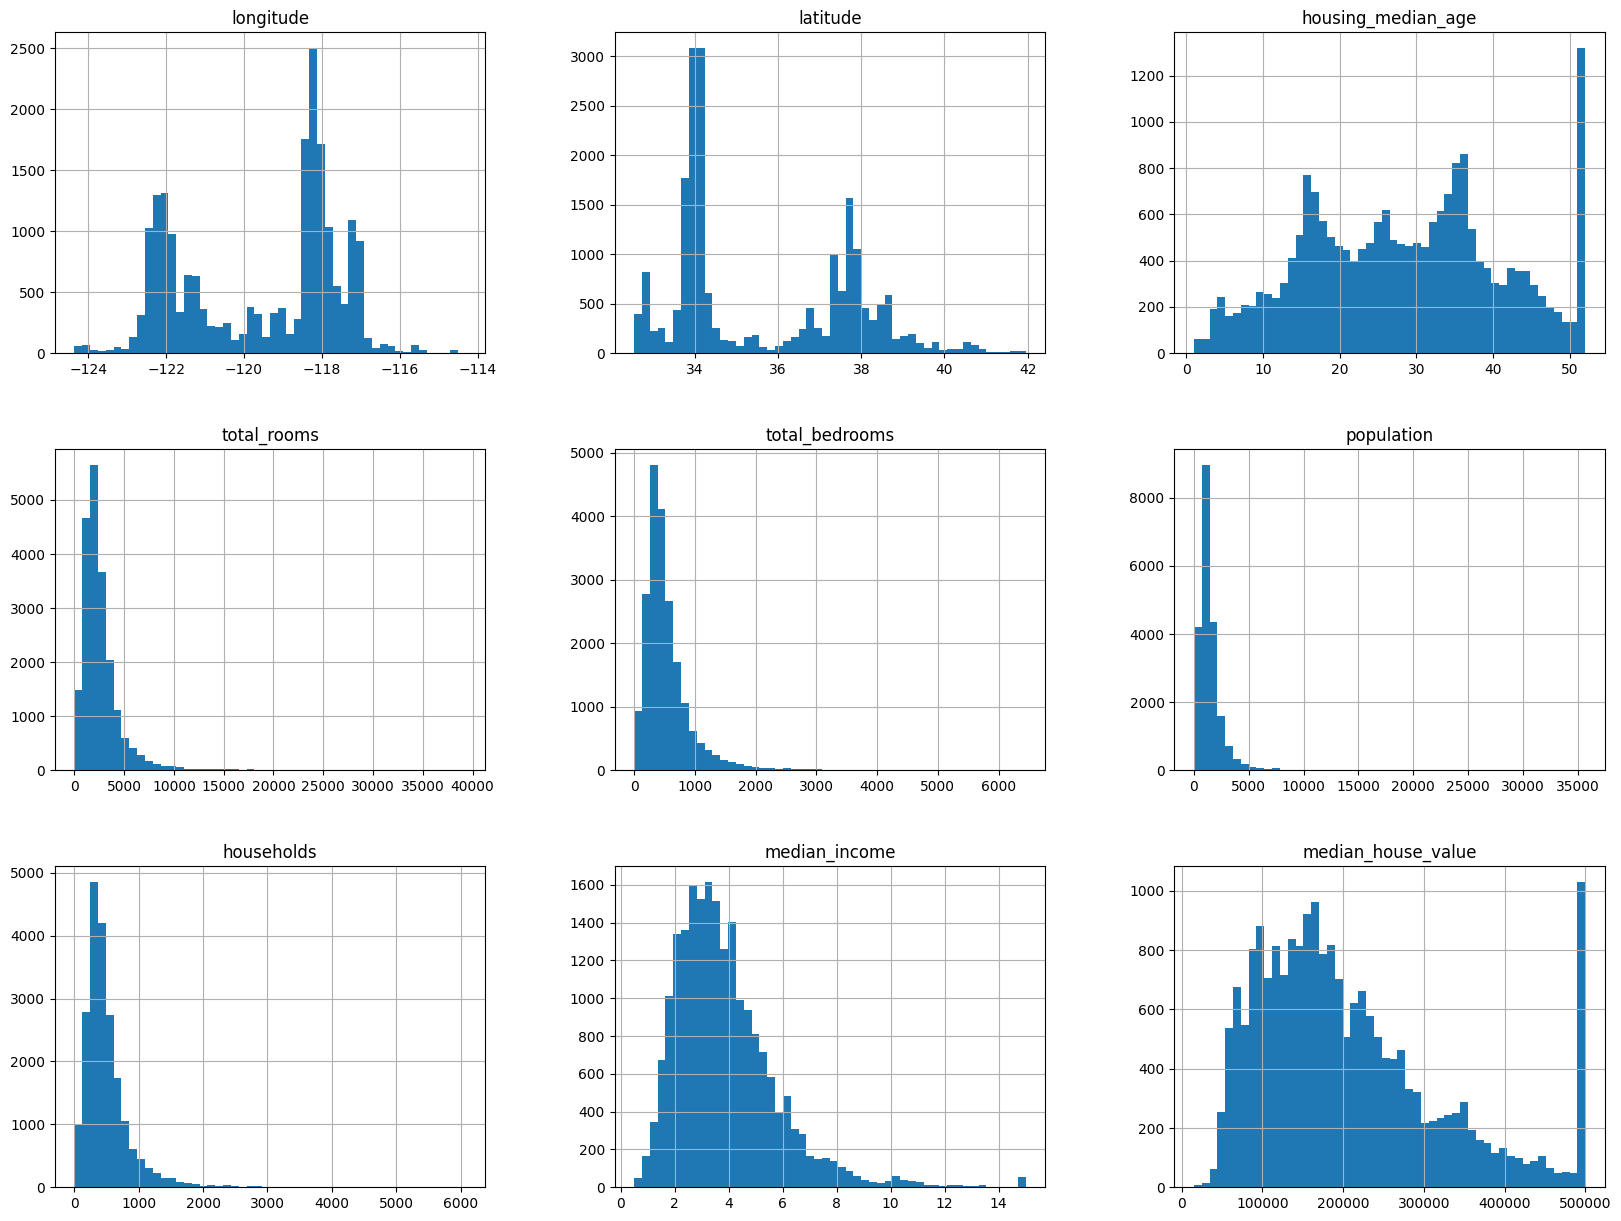

In [8]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

# Data Preparation

#### Split Dataset Into Training Set and Test Set

**1. Random Split**

Shuffle the dataset then split it into train and test set.

In [9]:
def split_dataset(dataset, test_ratio=0.2):
    shuffled_dataset = np.random.permutation(len(dataset))
    test_size = int(len(dataset) * test_ratio)
    train_indecies = shuffled_dataset[test_size:]
    test_indecies = shuffled_dataset[:test_size]
    return dataset.iloc[train_indecies], dataset.iloc[test_indecies]

In [10]:
train_set, test_set = split_dataset(housing)

train_set.shape, test_set.shape

((16512, 10), (4128, 10))

Let's get a better insight about income by categorize continuous numbers.

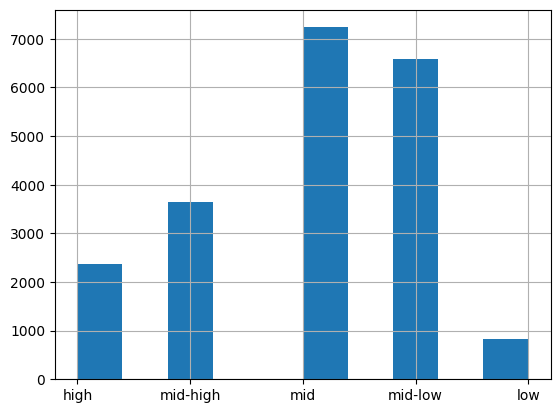

In [11]:
housing['income_category'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3., 4.5, 6., np.inf], labels=['low', 'mid-low', 'mid', 'mid-high', 'high'])

housing.income_category.hist()
plt.show()

**2. Stratisfied Shuffle Split**

This method solve the problem of baised sampling which may cause by Random Splitting, it splits the dataset according to the population ditribution, so the samples better represnts the population.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

partition = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=44)
for train_index, test_index in partition.split(housing, housing['income_category']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Show the percentage of each category.

In [13]:
strat_test_set.income_category.value_counts() / len(strat_test_set) * 100

income_category
mid         35.053295
mid-low     31.879845
mid-high    17.635659
high        11.434109
low          3.997093
Name: count, dtype: float64

In [14]:
strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
13446,-117.43,34.07,18.0,2453.0,537.0,1503.0,500.0,2.3768,95300.0,INLAND,mid-low
2664,-123.78,40.05,17.0,2019.0,496.0,899.0,347.0,2.1864,101900.0,<1H OCEAN,mid-low
5864,-118.34,34.18,45.0,3046.0,633.0,1448.0,599.0,3.2400,226900.0,<1H OCEAN,mid
17370,-120.43,34.98,21.0,2725.0,514.0,1466.0,488.0,3.6639,128600.0,<1H OCEAN,mid
19196,-122.70,38.44,45.0,883.0,202.0,401.0,194.0,3.2845,178300.0,<1H OCEAN,mid


In [15]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_category", axis=1, inplace=True)

In [16]:
housing_train = strat_train_set.copy()

In [17]:
housing_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
18869,-122.22,38.10,44.0,3013.0,563.0,1353.0,512.0,3.4559,111900.0,NEAR BAY
4291,-118.30,34.10,36.0,2284.0,899.0,1964.0,839.0,1.9297,203300.0,<1H OCEAN
16094,-122.50,37.76,50.0,1993.0,410.0,1009.0,374.0,3.9464,295600.0,NEAR OCEAN
3785,-118.38,34.16,31.0,2197.0,501.0,944.0,474.0,3.7312,319400.0,<1H OCEAN
8559,-118.41,33.92,32.0,2590.0,607.0,1132.0,555.0,4.2333,358000.0,<1H OCEAN


Now we plot the coordinations of each district to visualize it.

<Axes: xlabel='longitude', ylabel='latitude'>

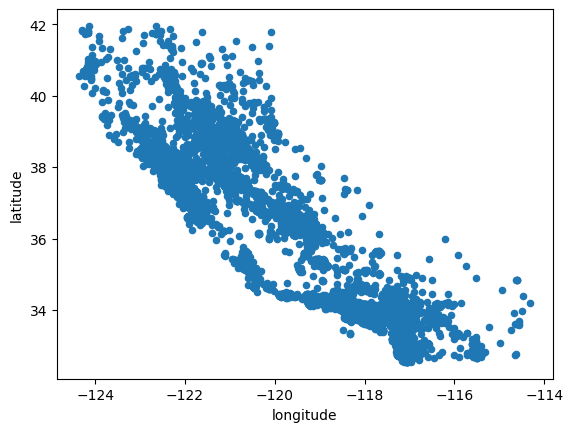

In [18]:
housing_train.plot(kind='scatter', x='longitude', y='latitude')

The visualization shows us that the dataset is representing California, but it is hard to address any pattern, so let's show density by reducing the opacity of points.

<Axes: xlabel='longitude', ylabel='latitude'>

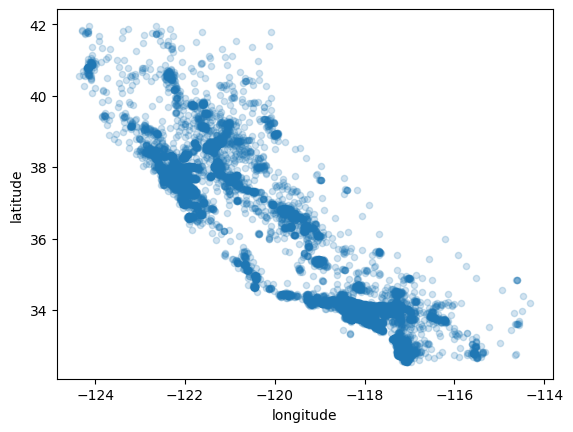

In [19]:
housing_train.plot(kind='scatter', x='longitude', y='latitude', alpha=.2)

That is a clearer represntation of our data, now let's show the median price of each district by setting a color and the population by changing circles area.

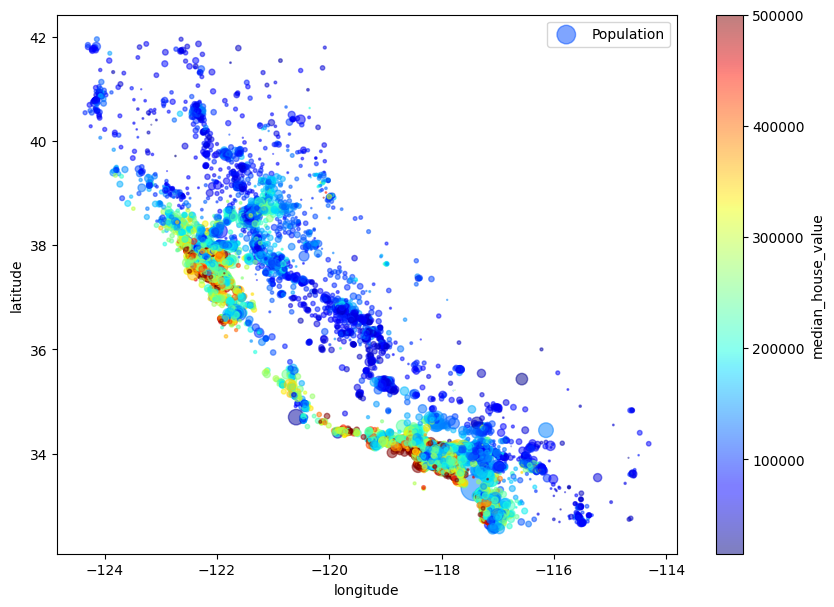

In [20]:
housing_train.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5, 
                   s=housing_train.population / 100, label='Population', c='median_house_value', 
                   cmap=plt.get_cmap('jet'), colorbar=True, figsize=(10, 7))
plt.legend()

### Data Correlation

Note that we should drop non-numerical data because we can NOT deal with non-numeric attributes yet.

In [21]:
corrrlation = housing_train.drop('ocean_proximity', axis=1).corr()
corrrlation['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688540
total_rooms           0.128717
housing_median_age    0.106829
households            0.062599
total_bedrooms        0.045385
population           -0.026837
longitude            -0.045161
latitude             -0.144383
Name: median_house_value, dtype: float64

#### Plotting Correlation Matrix 

To understand the correlation between our data let's visualize this correlation by plotting the correlation matrix.

Note that correlation between any atterbiute and itself should be 1 (a straight line), so pandas will plot a histogram instead.

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

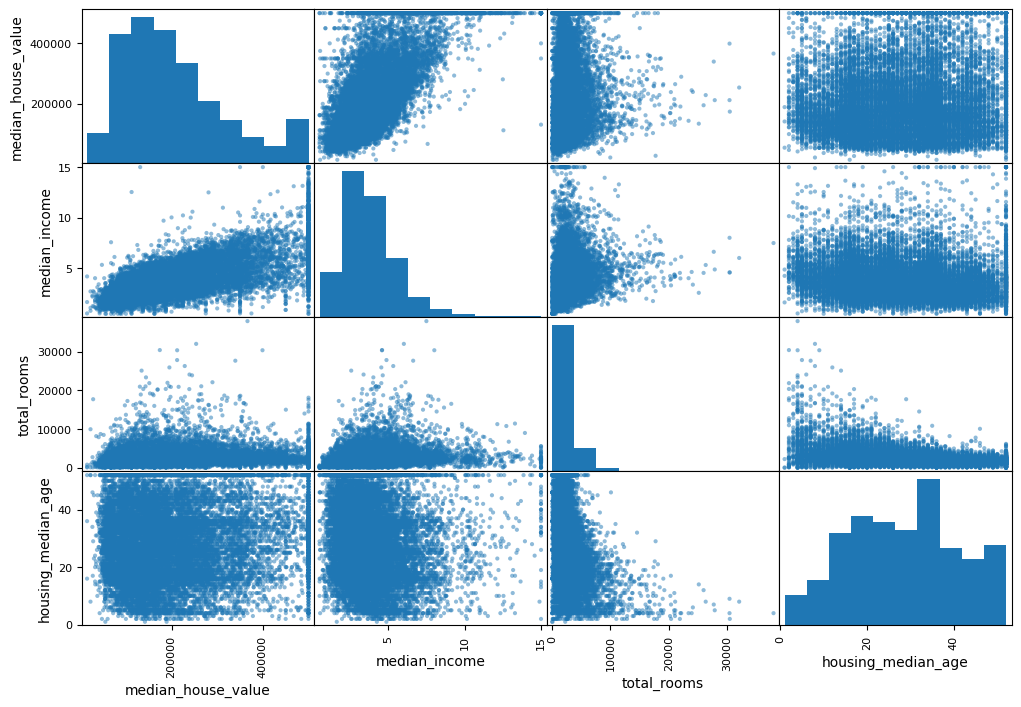

In [22]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(housing_train[attributes], figsize=(12, 8))

By plotting the correlation matrix we noticed that the most correlated attribute with the `median_house_value` is the `median_income`. Let's extract the plot for better insights.

<Axes: xlabel='median_income', ylabel='median_house_value'>

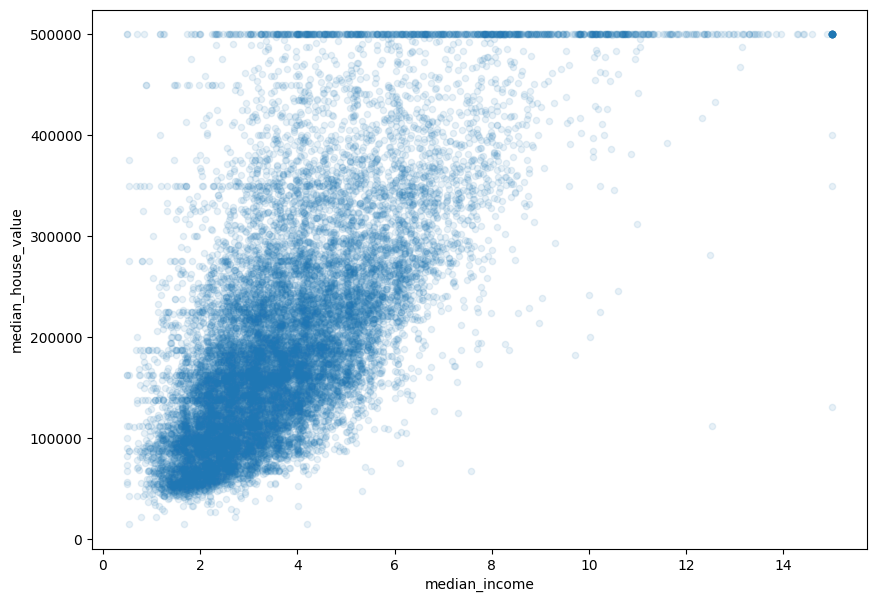

In [23]:
housing_train.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(10, 7))

### Try More Atteributes and Show How Better Correlated They Are.

    The ratio between two atteributes may have better correlation to the target than the separate atteributes.

In [24]:
housing_train['rooms_per_household'] = housing_train['total_rooms'] / housing_train['households']
housing_train['bedrooms_per_rooms'] = housing_train['total_bedrooms'] / housing_train['total_rooms']
housing_train['population_per_household'] = housing_train['population'] / housing_train['households']

corrrlation = housing_train.drop('ocean_proximity', axis=1).corr()
corrrlation['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688540
rooms_per_household         0.165097
total_rooms                 0.128717
housing_median_age          0.106829
households                  0.062599
total_bedrooms              0.045385
population                 -0.026837
population_per_household   -0.032135
longitude                  -0.045161
latitude                   -0.144383
bedrooms_per_rooms         -0.254833
Name: median_house_value, dtype: float64

## Prepare The Data For The Machine Learning Algorithm

After having good insights about our data, let's have a fresh dataset to feed our trainig algorithm. The predictors should be separated from the labels.

In [25]:
housing_df = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
18869,-122.22,38.10,44.0,3013.0,563.0,1353.0,512.0,3.4559,NEAR BAY
4291,-118.30,34.10,36.0,2284.0,899.0,1964.0,839.0,1.9297,<1H OCEAN
16094,-122.50,37.76,50.0,1993.0,410.0,1009.0,374.0,3.9464,NEAR OCEAN
3785,-118.38,34.16,31.0,2197.0,501.0,944.0,474.0,3.7312,<1H OCEAN
8559,-118.41,33.92,32.0,2590.0,607.0,1132.0,555.0,4.2333,<1H OCEAN


# Data Cleaning

Missing values could cause a problem during model trainig, to avoid these problem we should handle the missing values by one of following techniques:
- Ignore the instances including missing features
- Ignore the attributes has missing data
- Fill the missing data with a specific value, such as 0, mean, median, mode, a special character, or any other strategy

In our case we chose to fill missing values with median.

In [26]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num = housing_df.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

imputer.statistics_

array([-118.49  ,   34.26  ,   29.    , 2130.5   ,  436.    , 1169.    ,
        411.    ,    3.5351])

In [27]:
housing_features = pd.DataFrame(imputer.transform(housing_num), columns=housing_num.columns, index=housing_num.index)

housing_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
18869,-122.22,38.10,44.0,3013.0,563.0,1353.0,512.0,3.4559
4291,-118.30,34.10,36.0,2284.0,899.0,1964.0,839.0,1.9297
16094,-122.50,37.76,50.0,1993.0,410.0,1009.0,374.0,3.9464
3785,-118.38,34.16,31.0,2197.0,501.0,944.0,474.0,3.7312
8559,-118.41,33.92,32.0,2590.0,607.0,1132.0,555.0,4.2333


## Working With Text Data

In machine learning, working with non-numerical data may cause a less effective model in most cases, so converting non-numeric data to numeric data is an awesome idea to increase the model effectiveness.

Let's have a look to `ocean_proximity` feature which is the non-numeric data in the housing dataset.

In [28]:
housing_df['ocean_proximity'].head(10)

18869      NEAR BAY
4291      <1H OCEAN
16094    NEAR OCEAN
3785      <1H OCEAN
8559      <1H OCEAN
19720        INLAND
2103         INLAND
6826      <1H OCEAN
15737      NEAR BAY
8222     NEAR OCEAN
Name: ocean_proximity, dtype: object

One of the solutions to convert the non-numerical data to numeric is **Ordinal Encoder**.

**Ordinal Encoder** converts categorical text data to numeric order.

In [29]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_encoded = ordinal_encoder.fit_transform(housing_df[['ocean_proximity']])
pd.DataFrame(housing_encoded).head(10)

,0
0,3.0
1,0.0
2,4.0
3,0.0
4,0.0
5,1.0
6,1.0
7,0.0
8,3.0
9,4.0


In [30]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Another solution in our case is the **One Hot Encoder**.

**One Hot Encoder** creates new columns represent categories, all the columns are set to zero except the desired category is set to one.

In [31]:
from sklearn.preprocessing import OneHotEncoder

hot_encoder = OneHotEncoder()
housing_encoded = hot_encoder.fit_transform(housing[['ocean_proximity']])
pd.DataFrame((housing_encoded.toarray())).head(10)

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,1.0,0.0


In [32]:
hot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

###

# User Defined Transformers

Sci-kit learn library provides custom transformer that can be made by users.

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_index = 3
bedrooms_index = 4
population_index = 5
households_index = 6

class CombinedAtteributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, rooms_index] / X[:, households_index]
        population_per_household = X[:, population_index] / X[:, households_index]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_index] / X[:, rooms_index]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [34]:
atteribs_adder = CombinedAtteributesAdder(add_bedrooms_per_room=False)
pd.DataFrame(atteribs_adder.transform(housing_df.values)).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-122.22,38.1,44.0,3013.0,563.0,1353.0,512.0,3.4559,NEAR BAY,5.884766,2.642578
1,-118.3,34.1,36.0,2284.0,899.0,1964.0,839.0,1.9297,<1H OCEAN,2.722288,2.340882
2,-122.5,37.76,50.0,1993.0,410.0,1009.0,374.0,3.9464,NEAR OCEAN,5.328877,2.697861
3,-118.38,34.16,31.0,2197.0,501.0,944.0,474.0,3.7312,<1H OCEAN,4.635021,1.991561
4,-118.41,33.92,32.0,2590.0,607.0,1132.0,555.0,4.2333,<1H OCEAN,4.666667,2.03964


# Pipelines

Pipelines combine sevral transormations to make a sequential data transformation with one step.

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('atteributes_addr', CombinedAtteributesAdder()),
    ('std_scaler', StandardScaler())
])

pd.DataFrame(num_pipeline.fit_transform(housing_num)).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.321062,1.151551,1.220173,0.170168,0.058838,-0.068110,0.028081,-0.217994,0.206747,-0.059125,-0.417181
1,0.635548,-0.717409,0.585459,-0.163637,0.855423,0.471933,0.878596,-1.016927,-1.177403,-0.106279,2.794340
2,-1.460820,0.992689,1.696208,-0.296884,-0.303892,-0.372160,-0.330851,0.038773,-0.036554,-0.050484,-0.124175
3,0.595617,-0.689374,0.188762,-0.203474,-0.088150,-0.429611,-0.070755,-0.073880,-0.340240,-0.160878,0.222500
4,0.580643,-0.801512,0.268102,-0.023521,0.163153,-0.263444,0.139923,0.188959,-0.326389,-0.153363,0.320744


Instead of dealing with numerical and non-numerical attributes separately then combine the outputs, we can use `Column Transformer` to transform the full dataset at once.

In [36]:
from sklearn.compose import ColumnTransformer

numerical_attrs = list(housing_num)
categorical_attrs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('numbers', num_pipeline, numerical_attrs),
    ('categories', OneHotEncoder(), categorical_attrs)
    ])

housing_prepared = full_pipeline.fit_transform(housing_df)

pd.DataFrame(housing_prepared).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.321062,1.151551,1.220173,0.170168,0.058838,-0.068110,0.028081,-0.217994,0.206747,-0.059125,-0.417181,0.0,0.0,0.0,1.0,0.0
1,0.635548,-0.717409,0.585459,-0.163637,0.855423,0.471933,0.878596,-1.016927,-1.177403,-0.106279,2.794340,1.0,0.0,0.0,0.0,0.0
2,-1.460820,0.992689,1.696208,-0.296884,-0.303892,-0.372160,-0.330851,0.038773,-0.036554,-0.050484,-0.124175,0.0,0.0,0.0,0.0,1.0
3,0.595617,-0.689374,0.188762,-0.203474,-0.088150,-0.429611,-0.070755,-0.073880,-0.340240,-0.160878,0.222500,1.0,0.0,0.0,0.0,0.0
4,0.580643,-0.801512,0.268102,-0.023521,0.163153,-0.263444,0.139923,0.188959,-0.326389,-0.153363,0.320744,1.0,0.0,0.0,0.0,0.0


# Choosing The Machine Learning Algorithm

To choose the optimum machine learning algorithm, it is common to try sevral algorithms and defferntiate between them.

The first algorithm we will try is the `Linear Regression` algorithm.

In [37]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(housing_prepared, housing_labels)

LinearRegression()

Let's try our model to have an estimation about its performance.

In [38]:
sample_data = housing.iloc[:10]
sample_labels = housing_labels.iloc[:10]
prepared_samples = full_pipeline.transform(sample_data)

print('Predictions')
pd.Series(linear_model.predict(prepared_samples))

Predictions


0    404796.228785
1    429509.580353
2    377377.472363
3    318569.316729
4    253282.632803
5    262624.224565
6    257052.862365
7    255783.985905
8    201066.540210
9    267414.683952
dtype: float64

In [39]:
print('Actual Labels')
pd.Series(sample_labels)

Actual Labels


18869    111900.0
4291     203300.0
16094    295600.0
3785     319400.0
8559     358000.0
19720     97900.0
2103      70100.0
6826     238300.0
15737    187500.0
8222      87500.0
Name: median_house_value, dtype: float64

## Training Evaluation

To evaluate the model we should have metrics that show how good it is.

One of the popular metrics is the `Root Mean Squared Error` that shows how far the models predictions from the actual labels.

In [40]:
from sklearn.metrics import mean_squared_error

predictions = linear_model.predict(housing_prepared)
mse = mean_squared_error(housing_labels, predictions)
rmse = np.sqrt(mse)
rmse

68182.06528882742

This Linear Regression model gives poor predictions. Let's try another algorithm.

The second algorithm in our testing list is the `Desicion Tree Regressor` algorithm.

In [41]:
from sklearn.tree import DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(housing_prepared, housing_labels)

dtr_predictions = dt_regressor.predict(housing_prepared)
dtr_mse = mean_squared_error(housing_labels, dtr_predictions)
dtr_rmse = np.sqrt(dtr_mse)
dtr_rmse

0.0

Thats incredible, our model performs well, but this is too good to be true.
The model fits the training data perfectly with no errors at all.

**It is sounds like to have an overfitting problem.**

To solve this issue we should evaluate our model on new data, but we can NOT show the test set to our model until we satisfied about it's performance. So let's create a new evaluation set using out training data, and call it a dev set.
One of the dev set creation techniques is K-FOLDS, which is creat amount of K sets. One of the folds will be the dev set, the rest will be for trainig our model. After completing the trainig and evaluating, the dev fold will change then we will train our model on the rest of folds, on and on until we train our model with all data and evaluate its performance with all data as well.

In [42]:
from sklearn.model_selection import cross_val_score

# CV means Cross Validation Folds, neg_mean_squared_error is The negative of mean squared error
dt_score = cross_val_score(dt_regressor, housing_prepared, housing_labels, 
                        cv=10, scoring='neg_mean_squared_error')

dt_rmse = np.sqrt(dt_score * -1)
print(f'Mean: {dt_rmse.mean()}, Standard Deviation: {dt_rmse.std()}')
print('Scores: ')
pd.Series(dt_rmse)

Mean: 69467.71873697628, Standard Deviation: 1978.2390274596478
Scores: 


0    67637.267728
1    71260.048788
2    70697.812709
3    72906.386259
4    71038.163852
5    67063.200612
6    67972.558715
7    66702.537525
8    68993.753565
9    70405.457616
dtype: float64

As we expected, the `Decision Tree Regressor` model performs badly on the validation set. It is a clear overfitting problem.
Let's try to evaluate the `Linear Regression` model the same way.

In [43]:
lr_score = cross_val_score(linear_model, housing_prepared, housing_labels, 
                           cv=10, scoring='neg_mean_squared_error')

lr_rmse = np.sqrt(lr_score * -1)
print(f'Mean: {lr_rmse.mean()}, Standard Deviation: {lr_rmse.std()}')
print('Scores: ')
pd.Series(lr_rmse)

Mean: 68478.60525214791, Standard Deviation: 2402.4716909503804
Scores: 


0    66776.803624
1    69049.319685
2    71219.195479
3    70865.351804
4    65542.938515
5    69869.831984
6    65532.275249
7    67286.691585
8    66222.446155
9    72421.198442
dtype: float64

Now Let's try another algorithm, the third algorithm called `Random Forest Regressor`, it is consist of a group of Decision Trees.

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor()
rf_regressor.fit(housing_prepared, housing_labels)

rfr_mse = mean_squared_error(housing_labels, rf_regressor.predict(housing_prepared))
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse

18432.921992121777

In [45]:
rf_score = cross_val_score(rf_regressor, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error')

rf_rmse = np.sqrt(rf_score * -1)
print(f'Mean: {rf_rmse.mean()}, Standard Deviation: {rf_rmse.std()}')
print('Scores: ')
pd.Series(rf_rmse)

Mean: 49685.36672889256, Standard Deviation: 1479.059331943948
Scores: 


0    49119.787611
1    49910.905382
2    51719.099575
3    50968.789410
4    48497.302451
5    48082.925727
6    49418.658018
7    47459.955583
8    49413.063165
9    52263.180367
dtype: float64

This model performs better on the cross validation, but still have an overfitting problem. For overfitting we have additional solutions rather than changing the machine learning algorithm, one of these solutions is getting more data if possible, in our case we will work only with the data we have. That takes us to another solution which is fine tune our model by regularizing it for example.

# Model Fine Tuning

Increasing models performance can be done by tuning the hyperparameters, the manual tuning may effect the performance positively, but it likely to take so much effort and time to have a good impact, `Grid Search Cross Validation` solves this problem by automating the hyperparameters tuning by trying out all combinations using cross validation.

In [46]:
from sklearn.model_selection import GridSearchCV

parameters_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
                   {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

f_regressor = RandomForestRegressor()
grid_search = GridSearchCV(f_regressor, parameters_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [47]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [48]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [49]:
gs_results = grid_search.cv_results_
for mean_score, params in zip(gs_results["mean_test_score"], gs_results["params"]):
    print(np.sqrt(-mean_score), params)

63273.423104750924 {'max_features': 2, 'n_estimators': 3}
54530.430987509644 {'max_features': 2, 'n_estimators': 10}
52515.736295060466 {'max_features': 2, 'n_estimators': 30}
59325.726859078226 {'max_features': 4, 'n_estimators': 3}
52135.3821814653 {'max_features': 4, 'n_estimators': 10}
50247.85408186103 {'max_features': 4, 'n_estimators': 30}
58156.61925378781 {'max_features': 6, 'n_estimators': 3}
51978.20802370847 {'max_features': 6, 'n_estimators': 10}
49410.31572785956 {'max_features': 6, 'n_estimators': 30}
57818.67628752219 {'max_features': 8, 'n_estimators': 3}
51767.14864378217 {'max_features': 8, 'n_estimators': 10}
49755.123056995166 {'max_features': 8, 'n_estimators': 30}
60946.84806708871 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53867.49313249818 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59849.9011442919 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51737.00726267885 {'bootstrap': False, 'max_features': 3, 'n_estimators':

That's looks slightly better, the model have error of 49,477 at `max_features` = 6, and `n_estimators` = 30. That is obviously better than 49,720 it has before, but not enough, let's try another hyperparameters tuning techniques.

The **Randomized Search Cross Validation** can be used like the previous mentioned **Grid Search Cross Validation**, but instead of trying the all combinations it evaluates a given number of random combinations by selecting a random value of the hyperparameters.

Another way for tuning the model is using **Ensamble Methods**, which is combining models that perform well.

### Feature Importance

Sci-kit learn provides an indicator of how important each feature to the desired target.

In [50]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.24776167e-02, 7.17507499e-02, 4.23407808e-02, 1.74016474e-02,
       1.65085857e-02, 1.59656802e-02, 1.66661682e-02, 3.73863051e-01,
       4.06061762e-02, 1.09594530e-01, 5.88788176e-02, 9.61721384e-03,
       1.45875538e-01, 6.43598806e-05, 3.18280010e-03, 5.20628427e-03])

In [51]:
# pair each feature with its importance
add_attrs = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
category_encoder = full_pipeline.named_transformers_['categories']
category_one_hot_attrs = list(category_encoder.categories_[0])
attrs = numerical_attrs + add_attrs + category_one_hot_attrs
list(zip(attrs, feature_importances))

[('longitude', 0.07247761674306165),
 ('latitude', 0.07175074990287808),
 ('housing_median_age', 0.04234078079852652),
 ('total_rooms', 0.01740164740442424),
 ('total_bedrooms', 0.016508585681804255),
 ('population', 0.015965680208881023),
 ('households', 0.016666168219117882),
 ('median_income', 0.3738630506564198),
 ('rooms_per_household', 0.04060617621148686),
 ('population_per_household', 0.10959453032351996),
 ('bedrooms_per_room', 0.05887881760306134),
 ('<1H OCEAN', 0.00961721383514045),
 ('INLAND', 0.14587553816154744),
 ('ISLAND', 6.435988058576597e-05),
 ('NEAR BAY', 0.0031828001036844212),
 ('NEAR OCEAN', 0.005206284265860286)]

It looks like the `ocean_proximity` effects the output the most, that should be in consideration while selecting features to feed the model.

# Model Evaluation

After increasing efficiency of the model, now it's time for testing its performance when dealing with new data.

In [52]:
model = grid_search.best_estimator_

X_test_unprepared = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test = full_pipeline.transform(X_test_unprepared)

test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_rmse

50644.94539524217

Our model gets approximately 51  root mean squared error on the test set.